## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker, colors
from scipy import integrate, signal
import sympy

In [2]:
# Set font size of plot elements\n",
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Functions

In [3]:
def photons_from_temp(ω_c, temp):
    hbar_ov_k = 7.639e-12
    return (np.exp(hbar_ov_k * ω_c / temp) - 1) ** -1

In [4]:
def temp_from_photons(ω_c, num_photons):
    hbar_ov_k = 7.639e-12 
    return hbar_ov_k * ω_c / np.log(1 / num_photons + 1)

In [5]:
def nv_noise(ω, κ, γ, r, g, nT, nc):
    """
    function for calculating the number noise photons in the output port of the cavity-NV ensemble setup
    :param ω:         the frequency range over which the integration is performed
    :param κ:         the coupling rate of the input port
    ;param γ:         the internal loss rate of the cavity
    :param r:         the inhomogenous broadening of the spins
    :param g:         the collective coupling strength of the NV ensemble to the cavity
    :param nT:        the number of thermal photons at temperature T
    :param nc:        the number of effective photons from the spins
    :return:          the number of noise photons in the output port
    """
    # Define the numerator in parts
    num = (r ** 2 / 4 + ω ** 2) * κ * γ * nT + κ * r * g ** 2 * nc

    # Define the denominator
    den = np.abs(((κ + γ) / 2 - 1j * ω) * (r / 2 - 1j * ω) + g ** 2) ** 2

    return integrate.simpson(1 / (2 * np.pi) * num / den, x=ω, axis=0)

In [6]:
def nv_signal(ω, κ, γ, r, g, S):
    """
    function for calculating the number of signal photons in the output port of the cavity-NV ensemble setup
    :param ω:         the frequency range over which the integration is performed
    :param κ:         the coupling rate of the input port
    ;param γ:         the internal loss rate of the cavity
    :param r:         the inhomogenous broadening of the spins
    :param g:         the collective coupling strength of the NV ensemble to the cavity
    :param S:         the power spectral density of the input signal
    :return:          the number of signal photons in the output port
    """
    # Define the numerator
    num = (r ** 2 / 4 + ω ** 2) * κ ** 2

    # Define the denominator
    den = np.abs(((κ + γ) / 2 - 1j * ω) * (r / 2 - 1j * ω) + g ** 2) ** 2

    return integrate.simpson(1 / (2 * np.pi) * num / den * S, x=ω, axis=0)

In [7]:
def nv_output(ω, κ, γ, r, g, nT, nc, S):
    num = (r ** 2 / 4 + ω ** 2) * (κ * γ * nT + κ ** 2 * S) + κ * r * g ** 2 * nc
    den = np.abs(((κ + γ) / 2 - 1j * ω) * (r / 2 - 1j * ω) + g ** 2) ** 2
    return integrate.simpson(1 / (2 * np.pi) * num / den, x=ω, axis=0)

In [8]:
def bare_cav_noise(ω, κ, γ, nT):
    num = κ * γ * nT
    den = np.abs((κ + γ) / 2 - 1j * ω) ** 2
    return integrate.simpson(1 / (2 * np.pi) * num / den, x=ω, axis=0)

In [9]:
def bare_cav_signal(ω, κ, γ, S):
    num = ((κ - γ) ** 2 / 4 + ω ** 2) * S
    den = np.abs((κ + γ) / 2 - 1j * ω) ** 2
    return integrate.simpson(1 / (2 * np.pi) * num / den, x=ω, axis=0)

In [10]:
def bare_cav_output(ω, κ, γ, nT, S):
    num = κ * γ * nT + ((κ - γ) ** 2 / 4 + ω ** 2) * S
    den = np.abs((κ + γ) / 2 - 1j * ω) ** 2
    return integrate.simpson(1 / (2 * np.pi) * num / den, x=ω, axis=0)

## Bare Cavity Results

In [11]:
# Define cavity parameters
ωc = 2 * np.pi * 2.87e9
Q = 1e6
γ = ωc / Q

# Define temperature
T = 300
nT = photons_from_temp(ωc, T)

# Define signal
S = 10 * nT

In [12]:
# Define frequency range
ω = 2 * np.pi * np.linspace(-5, 5, 1000) * 1e4

# Calculate the input noise and signal over this bandwidth
input_noise = 2 * ω[-1] * nT / (2 * np.pi)
input_signal = 2 * ω[-1] * S / (2 * np.pi)

In [13]:
# Define ranges for κ
κ = np.logspace(3, 6, 100)

# Create meshgrid
κm, ωm = np.meshgrid(κ, ω)

In [24]:
# Calculate the signal and noise
bc_signal = bare_cav_signal(ωm, κm, γ, S)
bc_noise = bare_cav_noise(ωm, κm, γ, nT)

# Also calculate the signal if the cavity has zero noise to obtain the reflected portion
# Actually, this isn't required because its just the same as the signal term
bc_zero_temp = bare_cav_output(ωm, κm, γ, 0, S)
print(np.allclose(bc_signal, bc_zero_temp))

True
True


In [16]:
# Define our attenuation factor using the ratio of the output signal to the input signal
α_bc = bc_signal / input_signal

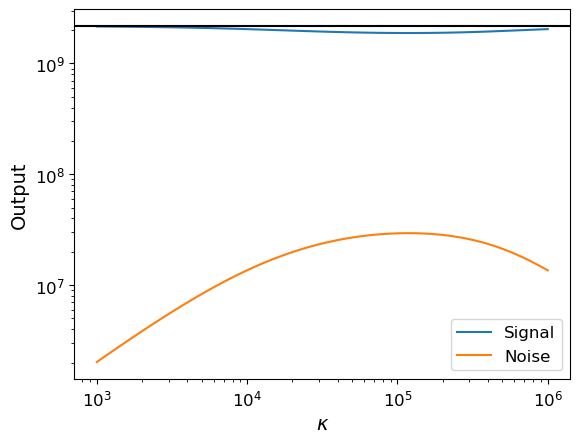

In [17]:
# Plot the attenuation coefficient vs the noise
plt.plot(κm[0], bc_signal, label='Signal')
plt.plot(κm[0], bc_noise, label='Noise')
plt.xlabel("$\\kappa$")
plt.ylabel("Output")
plt.axhline(y=input_signal, color='k')
plt.xscale('log')
plt.yscale('log')
plt.legend()

## NV Ensemble Results

In [18]:
# We'll start with a good NV ensemble setup
g = 1e6
r = 2 * g
P = 0.8
nc = 0.5 * (1 - P) / P

In [19]:
# Calculate the noise and signal photons over the same sweep used above
nv_noise = nv_noise(ωm, κm, γ, g, r, nT, nc)
nv_signal = nv_signal(ωm, κm, γ, g, r, S)

In [20]:
# Define our attenuation factor using the ratio of the output signal to the input signal
α_nv = nv_signal / input_signal

Text(0, 0.5, 'Noise')

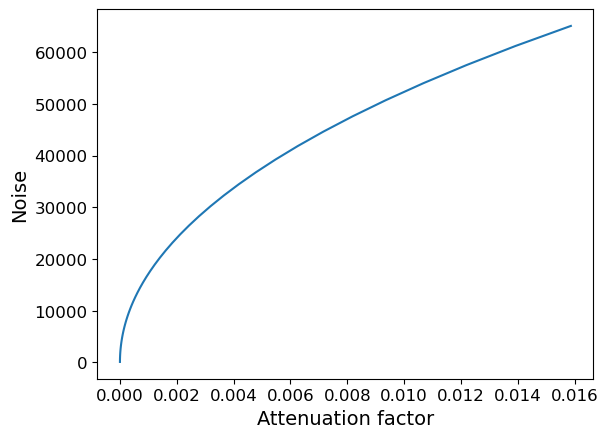

In [21]:
# Plot the attenuation coefficient vs the noise
plt.plot(α_nv, nv_noise)
plt.xlabel("Attenuation factor")
plt.ylabel("Noise")

## Comparison

Let's try defining an attenuation coefficient as the ratio of the output signal to the original and then plotting that against the noise and signal levels.